L'enjeu de ce TP est de pouvoir prédire l'auteur d'un tweet basé sur les historiques de publications des potentiels auteurs. 

## **1. Installation des packages**

In [ ]:
!pip install scattertext
!pip install spacy
!pip install nltk
!pip install emot

     |████████████████████████████████| 7.3MB 9.4MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9299 sha256=7bf5dc9bea6cb6100092493e9c07c129bc98b1359d731458114acd6dc6c29e34
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext


In [ ]:
!python -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6MB 1.3MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=7c15ac4907113fbe46ad9f7474c3283f10fcc26b16d0167ab498a10cca6c0cf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-yg3miowo/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Modules de traitement du texte
import spacy
import fr_core_news_md
import nltk
import re
from termcolor import colored
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Modules pour le wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Module pour scattertext
import scattertext as st

# Modules de modélisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report

In [ ]:
# chemin où se trouve le jeu de données (tweets_JLM_MLP_EM.csv)
PATH_DATA = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


## **2. Prise en main de la base de données**

Les données ont été extraites via l'API tweepy dans un autre notebook. \
Les tweets de Jean-Luc Mélenchon, de Marine Le Pen et de Emmanuel Macron ont été récupérés. 

Regardez les variables à disposition, quelques comptages, s'il y a des données manquantes, quelques graphiques (?), la spécificité des tweets, etc. 

#### Import des données

In [ ]:
df_tweets = pd.read_csv('{}/tweets_JLM_MLP_EM.csv'.format(PATH_DATA),encoding="utf-8")

# ou si le csv est directement dans votre jupyter : 
# df_tweets = pd.read_csv('tweets_JLM_MLP_EM.csv')

In [ ]:
df_tweets.shape

(7690, 6)

In [ ]:
df_tweets.head()

,id,created_at,favorite_count,retweet_count,text,user_id
0,1355788407344164865,2021-01-31 08:02:00,628,223,Il faut imaginer une autre façon de vivre. #OE...,JLMelenchon
1,1355687094627274760,2021-01-31 01:19:25,541,213,Ils ont transformé le Bac en marchandise. Et v...,JLMelenchon
2,1355683811976237057,2021-01-31 01:06:22,434,169,La Commune appartient à l'histoire de France. ...,JLMelenchon
3,1355680607657996288,2021-01-31 00:53:38,363,139,"Ce qui compte c'est les idées, et plus exactem...",JLMelenchon
4,1355679024404713474,2021-01-31 00:47:21,479,189,La situation des étudiants était prévisible. A...,JLMelenchon


####  Quelques comptages / graphiques

##### Indicateurs simples sur les variables : 
- Y a't'il des données manquantes ? 
- combien de tweets de MLP et JLM ? 
- dates minimales / maximales des tweets
- Distribution des favoris et des retweets de MLP et JLM

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utiliser .isnull() </li>
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html" >pd.value_counts()</a> pour compter le nombre de modalités d'une variable catégorielle </li>
    <li> Convertir la date au bon format avec pd.to_datetime() </li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [ ]:
# Implémentez la fonction en changeant le None
def check_missing_values(df):
  print("check for missing values : ")
  print(df.isnull().sum()/len(df))  
  return None

check_missing_values(df_tweets)
# Vous pouvez également utiliser df.info()

check for missing values : 
id                0.0
created_at        0.0
favorite_count    0.0
retweet_count     0.0
text              0.0
user_id           0.0
dtype: float64


In [ ]:
# Combien de tweets dans la base de données pour chacun des 2 politiques ? 
df_tweets["user_id"].value_counts()
# ou df_tweets["user_id"].value_counts(normalize=True) si vous voulez avoir les pourcentages

EmmanuelMacron    2897
MLP_officiel      2559
JLMelenchon       2234
Name: user_id, dtype: int64

In [ ]:
# A quelles dates ont été envoyés les premiers / derniers tweets de JML et MLP ? 
df_tweets["created_at"] = pd.to_datetime(df_tweets['created_at'])
df_tweets.groupby(["user_id"])["created_at"].apply(lambda x  : [x.min(), x.max()])

user_id
EmmanuelMacron    [2018-05-01 18:40:31, 2021-01-30 17:08:01]
JLMelenchon       [2020-04-19 09:59:47, 2021-01-31 08:02:00]
MLP_officiel      [2019-01-19 16:05:02, 2021-01-29 21:02:28]
Name: created_at, dtype: object

In [ ]:
# Quelle est la distribution des favoris et retweets de MLP et JLM  ?
df_tweets.groupby(["user_id"])[["favorite_count", "retweet_count"]].describe()

favorite_count                             ... retweet_count                
                        count         mean           std  ...           50%    75%      max
user_id                                                   ...                              
EmmanuelMacron         2897.0  5506.235416  13867.602674  ...         448.0  908.0  71405.0
JLMelenchon            2234.0   742.933751   2288.676408  ...          93.0  299.0  27751.0
MLP_officiel           2559.0  1172.197733   1168.385382  ...         341.0  626.0   4219.0

[3 rows x 16 columns]

##### Répartition du nombre de retweets / favoris dans le temps 

In [ ]:
def visualize_count_favorites(df, userID) : 
  
  ''' Cette fonction permet de visualiser le nombre de favoris et de retweets 
  sur toute la période pour un user_id donné '''

  df_temp = df.loc[df["user_id"] == userID]
  ylabels = ["favorite_count", "retweet_count"]

  print("Représentation des nombres de retweets et de favoris de chaque tweet de {} par date".format(userID))
  fig = plt.figure(figsize=(13,3))
  fig.subplots_adjust(hspace=0.01,wspace=0.01)

  n_row = len(ylabels)
  n_col = 1
  for count, ylabel in enumerate(ylabels):
      ax = fig.add_subplot(n_row, n_col, count + 1)
      ax.plot(df_temp["created_at"], df_temp[ylabel])
      ax.set_ylabel(ylabel)
  
  plt.show()

Représentation des nombres de retweets et de favoris de chaque tweet de JLMelenchon par date


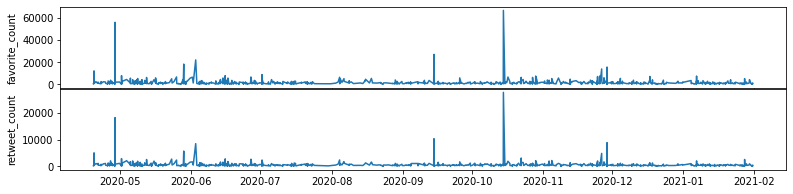



Représentation des nombres de retweets et de favoris de chaque tweet de MLP_officiel par date


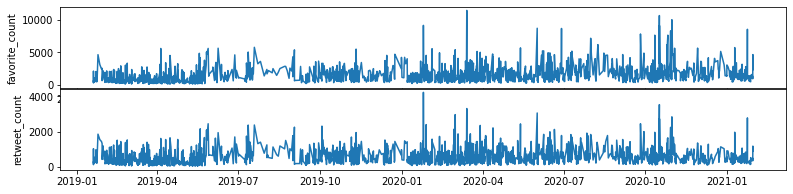

In [ ]:
visualize_count_favorites(df_tweets, "JLMelenchon")
print("\n")
visualize_count_favorites(df_tweets, "MLP_officiel")

> **Question** : Qu'observe-t'on ? 

**Réponse** : 
- JLM : 2 tweets ont été plus de 20K fois retweetés (alors qu'en moyenne, un tweet de JLM est retweeté 280 fois) et ont eu donc une grande popularité par rapport à son audience normale. 
- MLP a plutôt une audience stable, avec quelques tweets qui ont été plus retweetés (pic à 4K alors qu'en moyenne un tweet de MLP est retweeté 470 fois).

##### Taille des tweets par politique 

Est-ce que les tweets de MLP sont plus/moins longs que ceux de JLM ? 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utilisez la fonction <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html" >.split()</a> pour calculer la taille des tweets</li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [ ]:
# Calcul d'une variable contenant le nombre de mots de chaque tweets
df_tweets["lenght_tweet"] = df_tweets["text"].apply(lambda tweet : len(tweet.split()))

# Calcul de la distribution de la variable pour chaque politique
df_tweets.groupby(["user_id"]).lenght_tweet.describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
EmmanuelMacron,2897.0,28.575423,12.003363,1.0,19.0,29.0,39.0,57.0
JLMelenchon,2234.0,30.417189,11.141463,1.0,22.0,31.0,39.0,58.0
MLP_officiel,2559.0,35.613130,10.775029,1.0,30.0,38.0,43.0,55.0


In [ ]:
df_tweets.head(3)

,id,created_at,favorite_count,retweet_count,text,user_id,lenght_tweet
0,1355788407344164865,2021-01-31 08:02:00,628,223,Il faut imaginer une autre façon de vivre. #OE...,JLMelenchon,10
1,1355687094627274760,2021-01-31 01:19:25,541,213,Ils ont transformé le Bac en marchandise. Et v...,JLMelenchon,44
2,1355683811976237057,2021-01-31 01:06:22,434,169,La Commune appartient à l'histoire de France. ...,JLMelenchon,47


**Réponse** : En moyenne, MLP fait des tweets plus longs que les autres. 

##### Lecture de quelques tweets

In [ ]:
def print_famous_tweets(userID, nb_favorites) :

  ''' Cette fonction permet de sélectionner les tweets qui ont eu le plus de favoris 
  pour un user_id donné, et de lire le tweet avec les indicateurs des autres variables de la 
  base de données  
  '''

  df_sub = df_tweets.loc[(df_tweets.user_id==userID) & (df_tweets.favorite_count > nb_favorites),:]
  for irow in range(df_sub.shape[0]):
      df_row = df_sub.iloc[irow,:]
    
      print(df_row["created_at"])
      print("favorite_count={:6} retweet_count={:6}".format(df_row["favorite_count"],df_row["retweet_count"]))
      print(colored(df_row["text"], 'magenta'))
      print("\n")

In [ ]:
print_famous_tweets("JLMelenchon", 20000)

2020-10-14 18:38:21
favorite_count= 66651 retweet_count= 27751
60 % des contaminations ont lieu au travail ou à l'école ou à l'université entre 8h et 19h. 

Mais #Macron interdit les sorties au bar et au restau entre 20h et 6h. 

Bienvenue en Absurdie.

#macron20h #CouvreFeu #COVID19france


2020-09-14 13:41:47
favorite_count= 26941 retweet_count= 10319
La haine contre la 2ème religion du pays n'a donc plus de limite. https://t.co/0latKIG78G


2020-06-02 21:42:01
favorite_count= 21947 retweet_count=  8461
#Castaner ! La violence c'est vous et votre préfet qui la provoquez ! Ça suffit ! Le pays mérite mieux que votre jeu d'apprenti sorcier. Donald Trump n'est pas un modèle. #JusticePourAdama


2020-04-28 19:56:04
favorite_count= 55881 retweet_count= 18265
J'ai pas compris. Le #11mai il déconfine les coiffeurs oui ou non ? #DirectAN https://t.co/3s2ml69ful https://t.co/XWTCpZr4j5




In [ ]:
print_famous_tweets("MLP_officiel", 10000)

> **Question** : Qu'y-a't'il de particulier dans les tweets par rapport à un texte normal ?

**Réponse** : On voit que les tweets ont une syntaxe particulère : 
- hashtags 
- liens internet
- émojis

## **3. Preprocessing du texte**

On va prendre en compte les particularités des tweets pour nettoyer le texte. \
On va tester les techniques de preprocessing des cours précédents sur du texte français : 
- stopwords
- lemmatisation
- tokenisation


### Nettoyage du texte
Dans cette partie du TP, on nettoie le texte pour enlever les mots qui vont rajouter du bruit à l'analyse (et ne rien apporter) \
Pour nettoyer le texte : 
- conversation des emojis en texte
- suppression de certaines expressions grâce à des expressions régulières
- suppression des stopwords


In [ ]:
# on charge le modèle français de spacy
nlp = fr_core_news_md.load()

# On rajoute dans des stopwords à la liste de stopwords proposée par spacy
nlp.Defaults.stop_words |= {"mlp","a","faut","faire","monsieur","rendez-vous","direct",
                            "interview",r"invité\w+","dit","livetweet","suivez","celui",
                            "ce","cette","emot_right_arrow"}

# nombre de stopwords 
len(nlp.Defaults.stop_words)

611

> **Conseil** :  Regarder toujours la liste entière de stopwords proposés pour enlever certains mots qui seraient utiles dans votre étude ou rajouter des stopwords non présents dans la liste

Grâce au package emot et à la fonction ci-dessous, vous pouvez convertir les emojis dans les tweets en texte (pour ne pas perdre l'information qu'ils peuvent apporter à la suite de l'analyse)

In [ ]:
def convert_emojis(text):
  ''' Cette fonction transforme les emojis en texte qui commente par 
  emot_ puis la description en anglais de l'emoji.
  Certains emojis ne sont pas bien convertis (ex : certains drapeaux)'''
  for emot in UNICODE_EMO:
    name_emoticon = "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").replace("&","").split())
    name_emoticon = re.sub(r"[_-]+", "_", name_emoticon)
    name_emoticon = "emot_" + name_emoticon + " "
    text = text.replace(emot, name_emoticon + " ")
  text = re.sub(r"\s+", " ", text)
  return text

replique1 = "La ❓ elle est vite répondue 🤑🙄"
replique2 = "Mets-moi des 🎉 dans ma vie Kevin ! "

print(convert_emojis(replique1))
print(convert_emojis(replique2))

La emot_question_mark elle est vite répondue emot_money_mouth_face emot_face_with_rolling_eyes 
Mets-moi des emot_party_popper dans ma vie Kevin ! 


Expressions régulières pour nettoyer le texte 

In [ ]:
regexp_link = re.compile(r"http\S+") # suppression des liens
regexp_punctuation = re.compile("[,\./<>\?;':\"\[\]\\{}|`~!$%^&*()+-=«»’]") # suppression des ponctuations

# Rajout regexp après premier scattertext
regexp_frenchflag = re.compile("🇫🇷")

**TODO** : Créer une expression régulière pour supprimer les hashtags et @

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
Lorsque vous cherchez à créer des expressions régulières, vous pouvez vous aider en allant sur ce site : <a href="https://regex101.com/" >regex101.com</a> 
</p> 

In [ ]:
regexp_hashtags = re.compile(r"[#@]\w+")    # suppression des hashtags et @

In [ ]:
test_hashtags = "#Fuck ça #ne marche @pas !!"
re.sub(regexp_hashtags, "", test_hashtags)

' ça  marche  !!'

Création de la fonction de nettoyage du texte 

**TODO** : coder la fonction qui prend en entrée un tweet et  
- met les mots en minuscule
- supprime les mots des expressions régulières
- supprime les ponctuations
- supprime les stopwords
- lemmatise

In [ ]:
def remove_punct(doc):
  return [token for token in doc if not token.is_punct]


def remove_stop_words(doc):
  return [token for token in doc if not token.is_stop]


def lemmatize(doc):
   return ' '.join([token.lemma_ for token in doc])

In [ ]:
def preprocess_tweet(text, lemmatizing=True, delete_pos=False) : 

  '''Fonction permettant de nettoyer le texte. Elle renvoie un string (pas de tokenisation encore)'''
  
  emojis_converted = convert_emojis(text)
  french_flag_added = re.sub(regexp_frenchflag, "french_flag", emojis_converted)
  text_to_lower = french_flag_added.lower().encode('utf-8').decode('utf-8')
  text_no_link = re.sub(regexp_link, "", text_to_lower)
  text_no_hastags = re.sub(regexp_hashtags, "", text_no_link)
  
  # utilisation de spacy
  doc = nlp(text_no_hastags)
  removed_punct = remove_punct(doc)
  preprocessed_tweet = remove_stop_words(removed_punct)
  if lemmatizing :
    preprocessed_tweet = lemmatize(preprocessed_tweet)
    
  return(preprocessed_tweet)

In [ ]:
# exemple pour tester sa fonction 
tweet_test = "Ils Pensaient se moquer #non, ils m'ont donné un slogan !😄 \n\n- Entretien à découvrir et partager \n\nhttps://t.co/Yn60Areagu"
preprocess_tweet(tweet_test, lemmatizing=True, delete_pos=False)

'pensaient moquer donner slogan emot_smiling_face_with_open_mouth_smiling_eyes entretien découvrir partager'


Réponse attendue : 
```python 
'pensaient moquer donner slogan emot_smiling_face_with_open_mouth_smiling_eyes entretien découvrir partager'
```

In [ ]:
# On peut alors nettoyer nos tweets, et créer une nouvelle colonne, text_preprocess
# cela peut prendre un peu de temps... 
df_tweets["text_preprocess"] = df_tweets["text"].apply(lambda tweet : preprocess_tweet(tweet))

In [ ]:
# On regarde le résultat du nettoyage du texte
pd.set_option("max_colwidth", None)
df_tweets[["text", "text_preprocess"]].head(5)

,text,text_preprocess
0,Il faut imaginer une autre façon de vivre. #OEED https://t.co/LcMraG4YT8,falloir imaginer vivre
1,"Ils ont transformé le Bac en marchandise. Et voyez-vous, quand vous n'avez que cette possibilité pour vous élever dans la vie en étudiant sérieusement pour avoir un diplôme, vous êtes à cran quand il est question de rétablir une différence de classe. #OEED https://t.co/nbNVlhVSU7",transformer bac marchandise voyez avoir possibilité élever vie étudier sérieusement diplôme être cran question rétablir différence classe
2,La Commune appartient à l'histoire de France. Comme le pouvoir officiel est incapable de faire quoi que ce soit alors les gens s'organisent. La magie du moment c'est que les gens règlent les problèmes concrets eux-mêmes et se mettent à produire une masse de décisions. #OEED https://t.co/EmHaEJKSa3,commune appartenir histoire france pouvoir officiel incapable faire organiser magie moment régler problème concret mettre produire masse décision
3,"Ce qui compte c'est les idées, et plus exactement ce qu'on va faire pour ce pays. Par conséquent, on ne peut pas faire des soupes aux logos dans lesquelles, pour pouvoir s'entendre, on se tait sur tout. #OEED https://t.co/QvNsSbZ0v6",compte idée faire pays conséquent faire soupe logo pouvoir entendre taire
4,"La situation des étudiants était prévisible. Au mois de mai, des députés insoumis ont mis au point un plan pour les aider. Il faut les tirer de la précarité, il y a urgence. Commençons par la question matérielle en donnant le RSA aux jeunes de 18 à 25 ans. #OEED https://t.co/vEMFH7pc9v",situation étudiant prévisible mois mai député insoumis mettre point plan aider falloir tirer précarité y urgence commencer question matériel donner rsa jeune 18 25 an



> Le preprocess n'est pas encore parfait, on pourrait enlever les verbes avec du pos-tagging

### Tokenisation
On tokenise la colonne de tweets prétraités (preprocess)

**TODO** : utiliser le module nltk pour tokeniser un tweet avec la fonction tokenisation

In [ ]:
nltk.download('punkt') # nécessaire pour la tokenisation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Remplir le None dans le code
def tokenisation(tweet):
  tweet_tokenized = nltk.word_tokenize(tweet)
  return(tweet_tokenized)

In [ ]:
# On peut alors tokeniser nos tweets, et créer une nouvelle colonne, tokens
df_tweets["tokens"] = df_tweets["text_preprocess"].apply(lambda tweet : tokenisation(tweet))

In [ ]:
# On regarde le résultat de la tokenisation
df_tweets[["text_preprocess", "tokens"]].head()

,text_preprocess,tokens
0,falloir imaginer vivre,"[falloir, imaginer, vivre]"
1,transformer bac marchandise voyez avoir possibilité élever vie étudier sérieusement diplôme être cran question rétablir différence classe,"[transformer, bac, marchandise, voyez, avoir, possibilité, élever, vie, étudier, sérieusement, diplôme, être, cran, question, rétablir, différence, classe]"
2,commune appartenir histoire france pouvoir officiel incapable faire organiser magie moment régler problème concret mettre produire masse décision,"[commune, appartenir, histoire, france, pouvoir, officiel, incapable, faire, organiser, magie, moment, régler, problème, concret, mettre, produire, masse, décision]"
3,compte idée faire pays conséquent faire soupe logo pouvoir entendre taire,"[compte, idée, faire, pays, conséquent, faire, soupe, logo, pouvoir, entendre, taire]"
4,situation étudiant prévisible mois mai député insoumis mettre point plan aider falloir tirer précarité y urgence commencer question matériel donner rsa jeune 18 25 an,"[situation, étudiant, prévisible, mois, mai, député, insoumis, mettre, point, plan, aider, falloir, tirer, précarité, y, urgence, commencer, question, matériel, donner, rsa, jeune, 18, 25, an]"


### Analyse du preprocess

On regarde un peu les résultats du preprocessing : 
- combien y a-t-il de mots distincts pour chacun des deux hommes politiques ? 
- Quels sont les mots les plus utilisés par JLM et MLP ? 

Pour cela vous vous aiderez des deux fonctions données ci-dessous

In [ ]:
def create_big_tweet_by_userid(userid, col_text) : 
  ''' Fonction pour mettre tous les tweets de chaque politiciens dans un même text (string) '''
  one_big_tweet = " ".join(df_tweets.loc[df_tweets["user_id"] == userid, col_text])
  return(one_big_tweet)

In [ ]:
 def get_n_most_common_words(list_words, n) :
   ''' Fonction permettant de donner les n mots les plus fréquents d'une liste de mots '''
   freq_words = nltk.FreqDist(list_words)
   print(freq_words.most_common(n))

**TODO** : Si on n'utilise pas de preprocessing, quels sont les mots les plus utilisés par les 2 politiciens ?

In [ ]:
# Créer un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
one_big_tweet_jlm = create_big_tweet_by_userid('JLMelenchon', 'text')
one_big_tweet_mlp = create_big_tweet_by_userid('MLP_officiel', 'text')

# Tokeniser le gros tweet de chacun des politiques
tokens_jlm = tokenisation(one_big_tweet_jlm)
tokens_mlp = tokenisation(one_big_tweet_mlp)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_jlm, 10)
get_n_most_common_words(tokens_mlp, 10)

[('.', 4244), ('de', 2881), ('#', 2817), (':', 2240), ('la', 1963), (',', 1913), ('https', 1650), ('le', 1331), ('à', 1129), ('les', 1022)]
[(',', 4488), ('de', 4192), ('#', 3174), (':', 2970), ('’', 2622), ('.', 2531), ('la', 2441), ('https', 2354), ('à', 1943), ('et', 1880)]


**Réponse** : les mots les plus utilisés sont des stopwords ou des ponctuations

Sans preprocessing, combien y a-t-il de mots distincts pour chaque politique ?

In [ ]:
# la fonction set appliquée sur une liste donne une liste d'éléments uniques
print("Nombre de mots distincts dans les tweets de JL Mélenchon : {}".format(len(set(tokens_jlm))))
print("Nombre de mots distincts dans les tweets de Marine Le Pen : {}".format(len(set(tokens_mlp))))

Nombre de mots distincts dans les tweets de JL Mélenchon : 10568
Nombre de mots distincts dans les tweets de Marine Le Pen : 14163


**Réponse** : 

JLM : 10568\
MLP : 14163

**TODO** : même question avec un preprocessing ?


In [ ]:
# Créer un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
one_big_tweet_preprocess_jlm = create_big_tweet_by_userid('JLMelenchon', 'text_preprocess')
one_big_tweet_preprocess_mlp = create_big_tweet_by_userid('MLP_officiel', 'text_preprocess')

# Tokeniser le gros tweet de chacun des politiques
tokens_preprocess_jlm = tokenisation(one_big_tweet_preprocess_jlm)
tokens_preprocess_mlp = tokenisation(one_big_tweet_preprocess_mlp)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_preprocess_jlm, 10)
get_n_most_common_words(tokens_preprocess_mlp, 10)

[('falloir', 428), ('y', 310), ('faire', 292), ('france', 246), ('être', 166), ('pouvoir', 151), ('vouloir', 140), ('pays', 137), ('mettre', 136), ('️', 125)]
[('emot_video_camera', 568), ('français', 502), ('france', 343), ('être', 258), ('y', 255), ('européen', 248), ('gouvernement', 246), ('faire', 241), ('pays', 196), ('politique', 186)]


In [ ]:
print("Nombre de mots distincts dans les tweets de JL Mélenchon : {}".format(len(set(tokens_preprocess_jlm))))
print("Nombre de mots distincts dans les tweets de Marine Le Pen : {}".format(len(set(tokens_preprocess_mlp))))

**Réponse** : 

JLM : 5531\
MLP : 6787

### Nuage de mots

On trace un nuage de mots pour chacun des politiques pour voir ce qui ressort

**#TODO** : Faire un nuage de mots pour JLM et MLP avec 30 mots

In [ ]:
def create_wordcloud(text, nb_words):
  wordcloud = WordCloud(max_words=nb_words, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

Wordcloud des mots lemmatisés de l'ensemble des tweets de Jean-Luc Mélenchon


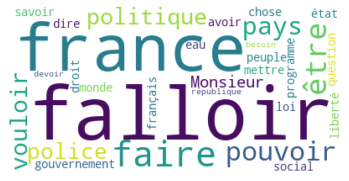

In [ ]:
lemat_jlm = " ".join(df_tweets.loc[df_tweets.user_id=="JLMelenchon", "text_preprocess"])
print("Wordcloud des mots lemmatisés de l'ensemble des tweets de Jean-Luc Mélenchon")
create_wordcloud(lemat_jlm, 30)

Wordcloud des mots lemmatisés de l'ensemble des tweets de Marine Le Pen


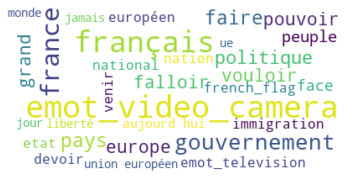

In [ ]:
lemat_mlp = " ".join(df_tweets.loc[df_tweets.user_id=="MLP_officiel", "text_preprocess"])
print("Wordcloud des mots lemmatisés de l'ensemble des tweets de Marine Le Pen")
create_wordcloud(lemat_mlp, 30)

C'est bien beau, mais c'est difficile à analyser, et surtout à comparer... \
On va utiliser scattertext pour comparer réellement le vocabulaire des 2 politiques.

## **4. Scattertext**

Grâce à Scattertext, on va pouvoir comparer de manière visuelle la distinction de vocabulaire utilisé par MLP et JLM. 


On doit d'abord construire un corpus avec nos données : 
- donner la variable de catégorie 
- donner la variable du texte

On peut rajouter le partie ```.compact(st.AssociationCompactor(4000))``` pour ne prendre en compte que les 4000 mots les plus importants dans le scattertext.

**TODO** : créer le corpus avec la fonction donnée ci-dessous

In [ ]:
# on crée un objet corpus pour scattertext
corpus = st.CorpusFromPandas(data_frame = df_tweets.loc[df_tweets.user_id != "EmmanuelMacron"],
                             category_col = "user_id",
                             text_col = "text_preprocess",
                             nlp = nlp).build().compact(st.AssociationCompactor(4000))

Une fois le corpus créé, on peut créer le html avec le scattertext.
 
On utilise la fonction ```st.produce_scattertext_explorer``` en donnant les paramètres vus pendant le cours : 
- term_ranker
- term_scorer
- transform 

**TODO** : remplir la fonction en réfléchissant aux paramètres que vous voulez tester.

In [ ]:
# On crée le html du scattertext
html = st.produce_scattertext_explorer(  corpus
                                       , category                  = 'JLMelenchon'
                                       , category_name             = 'Jean Luc Mélenchon'
                                       , not_category_name         = 'Marine Le Pen'
                                       , minimum_term_frequency    = 10
                                       , pmi_threshold_coefficient = 1
                                       , term_ranker               = st.AbsoluteFrequencyRanker
                                       , transform                 = st.Scalers.dense_rank
                                       , term_scorer               = st.RankDifference() 
#on peut égalemet tester le term_scorer ScaledFscore : st.ScaledFScorePresets(beta=1, one_to_neg_one=True)
                                       , width_in_pixels           = 1000
                                       )

# On enregistre le html
open("tweets_visualisation.html", 'wb').write(html.encode('utf-8'))

1387283

**TODO** : regarder le résultat (il apparaitra normalement dans le dossier content du notebook) en téléchargeant le html (cela peut prendre un petit moment avant de s'afficher correctement).

**Question** : On peut voir :
- les mots "stopwords" apparaitre en haut à droite : des verbes ainsi que des mots très utilisés dans le langage politique ("pays", "politique")
- En bas à droite, il y a les mots associés à MLP : "islamisme", "immigration", "nation", "frontière", drapeau français, et émojis
- En haut à gauche, il y a les mots associés à JLM : "dette", "monsieur", "police", "programme", "commun", "insoumis"

## **5. Modélisation**

On souhaite prédire si un tweet provient du compte de Marine Le Pen, de Jean Luc Mélenchon ou d'Emmanuel Macron. Pour cela, on a besoin de : 
- Créer un échantillon train / dev
- préparer le text (préprocessing)
- créer des features (plusieurs méthodes : counts of words, tfidf ou autre)
- réaliser l'algorithme
- évaluer la performance du modèle 

### Création des échantillons 

**TODO** : créer un échantillon train (70% du jeu de données total) et un échantillon test 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Utilisez la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" >train_test_split</a></li>
  <li> Prenez la colonne déjà tokenisés</li>
</p> 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tweets["text_preprocess"],
                                                    df_tweets["user_id"], 
                                                    test_size=0.3, 
                                                    random_state=123)

In [ ]:
# on vérifie que la répartition entre les user 
print(y_train.value_counts(normalize=True))
print("\n")
print(y_test.value_counts(normalize=True))

EmmanuelMacron    0.372840
MLP_officiel      0.339402
JLMelenchon       0.287758
Name: user_id, dtype: float64


EmmanuelMacron    0.385782
MLP_officiel      0.317295
JLMelenchon       0.296922
Name: user_id, dtype: float64


Les données sont plutôt équilibrées 

### Modèle de régression multinomiale sans gridsearch 

- Transformer le texte de X_train et X_test en vecteurs pour le modèle
- Utiliser la régression logistique multinomiale avec les paramètres par défaut
- Regarder les hyperparamètres par défaut sélectionnés
- Regarder le score sur l'échantillon test

**#TODO** : transformer X_train pour que ce ne soit plus des tweets, mais des vecteurs grâce à <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html" >TfidfVectorizer</a> (vous pouvez regarder les paramètres associés à la fonction)

In [ ]:
#TODO
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)

La fonction TfidfVectorizer a des paramètres que vous pouvez choisir : 
- Combien de n-grams : vous considérez mot par mot ou bien également des groupes de 2 mots
- max_df : si vous voulez enlever un pourcentage de mots les plus fréquents
- min_df : si vous voulez enlever un pourcentage de mots les moins fréquents

In [ ]:
# vous pouvez tester avec ngram_range =(1,2) ou ngram_range=1, 
# pour voir le nombre de variables créées dans le X_train 
# (attention, faites retourner le train_test_split avant)
X_train.shape

(5383, 68305)

**#TODO** : créer le modèle de régression logistique (OVR) et entrainer le modèle sur les données d'apprentissage

In [ ]:
# initialiser le modèle 
model = LogisticRegression(multi_class="ovr")

# entrainer le modèle avec les données d'apprentissage
model_without_grids = model.fit(X_train, y_train)

In [ ]:
# vous pouvez voir les paramètres du modèle 
model_without_grids

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Attention, la régression logistique de scikit learn permet de faire des modèles plus complexes qu'une régression logistique normale que vous avez vu en cours : avec les paramètres "penalty", vous créer en fait un modèle de régression logistique pénalisé (ridge ou lasso). \
<a href="https://towardsdatascience.com/the-basics-logistic-regression-and-regularization-828b0d2d206c" >article sur régression logistique pénalisée</a> \
<a href="https://towardsdatascience.com/penalized-regression-with-classification-f60bc663e8dc" >autre article</a>




**#TODO** : Regarder la performance du modèle sur l'échantillon test (accuracy)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> N'oubliez pas de transformer le texte de l'échantillon test en vecteur en amont</li>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">score</a>  du modèle</li>
  
</p> 

In [ ]:
X_test = vectorizer.transform(X_test)
model_without_grids.score(X_test, y_test) 
# Mon résultat est : 0.818

0.8183788469874296

**#TODO** : regarder plus en détail ce que donne le modèle : 

In [ ]:
print("le 1er tweet de l'échantillon test a été prédit : ")
print(model_without_grids.predict(X_test[0]))

le 1er tweet de l'échantillon test a été prédit : 
['MLP_officiel']


In [ ]:
print(model_without_grids.classes_) # pour connaître l'ordre des classes / des modèles
model_without_grids.predict_proba(X_test[0])

['EmmanuelMacron' 'JLMelenchon' 'MLP_officiel']


array([[0.24281623, 0.04187058, 0.7153132 ]])

**Question** : que retourne la ligne de code ci-dessus ?

**Réponse** : les résultats des 3 modèles de régression logistique que scikit learn a fait tourner (car on est en One VS rest). 

On voit donc que le 3e modèle qui prédit MLP VS reste, donne la probabilité la plus élevée (0.71 dans mon cas). Scikit learn prédit donc que le 1er tweet vient du compte de MLP

### Mise en Gridsearch

On veut mettre en place une gridsearch pour sélectionner les meilleurs hyperparamètres qu'on a choisi d'évaluer via la méthode de cross-validation : 
- on établit d'abord la grille de hyperparamètres que l'on veut tester
- on effectue la gridsearch
- on regarde les résultats sut l'échantillon test

In [ ]:
parameters = {u'C' : (1,20,50), # paramètre devant coefficient de pénalisation (penalty)
              u'penalty' : ['l1', 'l2'], # si c'est une régression lasso / ridge
              u'max_iter' : [500]
              }

**#TODO** : Entrainer la gridsearch avec les hyperparamètres ci-dessus sur les données d'apprentissage avec de la cross validation


<details>    
<summary>
    <font size="3"**texte en gras** color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a></li>
  
</p> 

In [ ]:
grid_search = GridSearchCV(LogisticRegression(multi_class="ovr"), 
                           parameters,
                           cv=10,  # cross validation de 10 échantillons
                           n_jobs=-1,
                           verbose=1)

In [ ]:
print(u"Performing grid search...")
print(u"parameters:")
print(parameters) 
t0 = time() 
grid_search.fit(X_train, y_train)
print(u"done in %0.3fs" % (time() - t0))
print(u'')
print(u'DEVELOPMENT SET')
print(u"Best score on the train set: %0.3f" % grid_search.best_score_)
print(u"Best parameters set on the train set:") 
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()): 
  print(u"\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'C': (1, 20, 50), 'penalty': ['l1', 'l2'], 'max_iter': [500]}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   52.5s finished


done in 58.851s

DEVELOPMENT SET
Best score on the train set: 0.832
Best parameters set on the train set:
	C: 50
	max_iter: 500
	penalty: 'l2'


Le modèle avec les hyperparamètres sélectionnés par cross validation a une performance de 0.833 en cross validation

**#TODO** : on évalue la performance en calculant l'accuracy du modèle de gridsearch sur l'échantillon test



In [ ]:
grid_search.score(X_test, y_test)

0.8274815778066753

Sur l'échantillon test, le modèle a une performance de 0.829

### Evaluation de la performance du modèle 

On va calculer la matrice de confusion sur l'échantillon test

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html" >plot_confusion_matrix</a></li>
  
</p> 

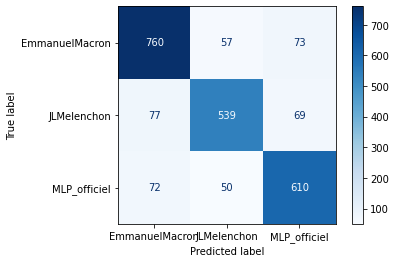

In [ ]:
#matrice de confusion
#confrontation entre Y obs. sur l’éch. test et la prédiction
disp = plot_confusion_matrix(grid_search, 
                             X_test, 
                             y_test,
                             cmap=plt.cm.Blues,
                             values_format=".3g")
plt.show()

**#TODO** : Interpréter les résultats 

**Question** : Sur l'ensemble des tweets de JLM, combien (pourcentage) ont bien été prédits JLM ?  

**Réponse** : 79% des tweets de JLM ont été prédits JLM par le modèle. 
``` 
539/(539+77+69) 
```

In [ ]:
#On peut aussi retrouver le résultat via cette fonction
print(classification_report(y_test, grid_search.predict(X_test)))

                precision    recall  f1-score   support

EmmanuelMacron       0.84      0.85      0.84       890
   JLMelenchon       0.83      0.79      0.81       685
  MLP_officiel       0.81      0.83      0.82       732

      accuracy                           0.83      2307
     macro avg       0.83      0.82      0.83      2307
  weighted avg       0.83      0.83      0.83      2307



### Test sur des nouvelles données :

Ces quelques tweets ont été récupérés après que la base de données ait été récupérée. Ce sont donc des nouvelles données que le modèle n'a jamais vu.

**#TODO** : Qui a publié ces tweets ? 

In [ ]:
new_tweets = ["On ne peut que condamner le coup d’Etat militaire en Birmanie, qui renvoie ce pays vers une situation que l’on espérait dépassée. Le fonctionnement constitutionnel régulier doit être assuré; Mme Aung San Suu KyI et les personnes arrêtées doivent être libérées sans délai. MLP", 
              "Non ! Les chemins de la raison ne s'ouvrent pas à la faux. Non ! La porte de l'universel ne s'ouvre pas à coups de pieds. Non ! L'amour de la République, comme tout amour, ne vaut rien sous la menace.", 
              "C’est par notre vigilance collective que nous réussirons. Tester, au moindre symptôme. Alerter, pour limiter la propagation. Protéger, en respectant l’isolement.",
              "Libéré, délivré, je ne mentirai plus jamais ! C'est décidé je m'en vais. L'hiver s'installe doucement dans la nuit, la neige est reine à son tour. Un royaume de solitude.",
              "Oui, ma gâtée, RS4 gris nardo, bien sûr qu'ils m'ont raté (gros, bien sûr). Soleil dans la bulle, sur le Prado, Shifter pro' (Shifter pro'). Contre-sens (ah), ma chérie, tu es à contre-sens"]

In [ ]:
X_mystere = pd.DataFrame(new_tweets, columns=["text"])
X_mystere = X_mystere.text.apply(lambda row : preprocess_tweet(row, lemmatizing=True))
X_tfidf_mystere = vectorizer.transform(X_mystere)
grid_search.predict(X_tfidf_mystere)

array(['MLP_officiel', 'JLMelenchon', 'EmmanuelMacron', 'EmmanuelMacron',
       'MLP_officiel'], dtype=object)

**Réponse attendue** :

```
array(['MLP_officiel', 'JLMelenchon', 'EmmanuelMacron', 'EmmanuelMacron',
       'MLP_officiel'], dtype=object)
```